In [1]:
%matplotlib widget
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import ipywidgets as widgets
from ipywidgets import interactive, HBox, Layout,VBox    

Le vecteur unitaire donnant la direction du champ primaire est

$$\boldsymbol{\hat{F}} = \begin{pmatrix} \cos(I)\cos(D)\\ \cos(I)\sin(D)\\ \sin(I) \end{pmatrix} .$$

Le vecteur du moment dipolaire est

$$\boldsymbol{m} = \begin{pmatrix} m_x\\ m_y\\ m_z \end{pmatrix} = m\begin{pmatrix} \cos(I)\cos(D)\\ \cos(I)\sin(D)\\ \sin(I) \end{pmatrix} .$$

La matrice hessienne du champ magnétique dipolaire est
$$\mathbf{J} = \begin{pmatrix} \frac{\partial^2}{\partial x^2} & \frac{\partial^2}{\partial x\partial y} & \frac{\partial^2}{\partial x\partial z} \\ \frac{\partial^2}{\partial y\partial x} & \frac{\partial^2}{\partial y^2} & \frac{\partial^2}{\partial y\partial z}\\ \frac{\partial^2}{\partial z\partial x} & \frac{\partial^2}{\partial z\partial y} & \frac{\partial^2}{\partial z^2} \end{pmatrix} \left(\frac{1}{r}\right) = \begin{pmatrix} \frac{3x^2}{r^5} - \frac{1}{r^3} & \frac{3xy}{r^5} & \frac{3xz}{r^5}\\ \frac{3xy}{r^5} & \frac{3y^2}{r^5} - \frac{1}{r^3} & \frac{3yz}{r^5}\\ \frac{3xz}{r^5} & \frac{3yz}{r^5} & \frac{3z^2}{r^5} - \frac{1}{r^3} \end{pmatrix} ,$$

où $r = \sqrt{x^2 + y^2 + z^2}$. Notez que $\mathbf{J}$ est une matrice symmétrique. On a donc pas besoin de la définir partout.

In [3]:
# Définir les constantes
C_m = 1e-7  # constante magnétique
mu_0 = np.pi*4e-7  # perméabilité du vide

In [4]:
@nb.njit()
def calculer_direction_m(I, D):
    # Retourne le vecteur des cosinus
    # directeurs de l'aimantation à
    # partir de I et D (en degrés)
    I, D = np.radians(I), np.radians(D)
    return np.array([np.cos(I)*np.cos(D), 
                     np.cos(I)*np.sin(D), 
                     np.sin(I)], dtype='float32')

In [5]:
@nb.njit()
def remplir_J(J, x, y, z):
    r = np.sqrt(x*x + y*y + z*z)
    # Construire la matrice J
    J[0, 0] = 3*x*x / r**5 - 1/r**3
    J[1, 1] = 3*y*y / r**5 - 1/r**3
    J[2, 2] = 3*z*z / r**5 - 1/r**3
    J[0, 1] = 3*x*y / r**5
    J[0, 2] = 3*x*z / r**5
    J[1, 2] = 3*y*z / r**5
    J[1, 0] = J[0, 1]
    J[2, 0] = J[0, 2]
    J[2, 1] = J[1, 2]
    # Principe de superposition 
    return J.sum(-1).sum(-1).sum(-1)

In [6]:
@nb.njit()
def meshgrid(x, y, z):
    xx = np.empty(shape=(y.size, x.size, z.size), dtype=x.dtype)
    yy = np.empty(shape=(y.size, x.size, z.size), dtype=y.dtype)
    zz = np.empty(shape=(y.size, x.size, z.size), dtype=z.dtype)
    for i in range(y.size):
        for j in range(x.size):
            for k in range(z.size):
                xx[i, j, k] = y[i]
                yy[i, j, k] = x[j]
                zz[i, j, k] = z[k]
    return yy, xx, zz

In [7]:
def calculer_dipole(x, y, z, x0, y0, z0, nx, ny, nz, I, D, F, chi):
    v = ((x0[1]-x0[0])/nx) * ((y0[1]-y0[0])/ny) * ((z0[1]-z0[0])/nz)
    x0 = np.linspace(x0[0], x0[1], nx, dtype='float32')
    y0 = np.linspace(y0[0], y0[1], ny, dtype='float32')
    z0 = np.linspace(z0[0], z0[1], nz, dtype='float32')
    x0, y0, z0 = meshgrid(x0, y0, z0)
    
    # Calcul des distances entre les 
    # points d'observation (x, y, z)
    # et les dipôles (x0, y0, z0)
    x = np.subtract.outer(x, x0)
    y = np.subtract.outer(y, y0)
    z = np.subtract.outer(z, z0)    

    m = chi*F*v/mu_0  # moment dipolaire
    m_chapeau = calculer_direction_m(I, D)  # vecteur unitaire direction de m
    J = np.empty((3, 3, *x.shape), dtype='float32')
    J = remplir_J(J, x, y, z)  # la matrice hessienne du champ dipolaire
    dF = C_m * np.tensordot(m * m_chapeau, J, axes=(0, 0))  # m*J
    dT = np.tensordot(m_chapeau, dF, axes=(0, 0))  # projection sur F
    return dT

In [8]:
# Définir les coordonnées des observations
x = np.linspace(-100, 100, 100, dtype='float32')  # m
y = np.linspace(-100, 100, 100, dtype='float32')  # m
z = np.array([0], dtype='float32')  # m
x, y, z, = meshgrid(x, y, z)

In [9]:
# Paramètres magnétiques
I = widgets.IntSlider(min=-90, max=90, step=1, value=90, description=r'$I$ ($^\circ$)')
D = widgets.IntSlider(min=0, max=360, step=1, value=0, description=r'$D$ ($^\circ$)')
F = widgets.IntSlider(min=10000, max=80000, value=55000, step=100, description='$F$ (nT)')
chi = widgets.FloatLogSlider(min=-6, max=0, value=1e-2, step=0.5, base=10, description=r'$\chi_m$ (SI)')
# Nombre de dipoles dans les directions x, y, z
nx = widgets.IntSlider(min=1, max=50, value=5, step=1, description='$N_x$')
ny = widgets.IntSlider(min=1, max=50, value=5, step=1, description='$N_y$')
nz = widgets.IntSlider(min=1, max=50, value=1, step=1, description='$N_z$')
# Positions des dipoles dans les directions x, y, z
x0 = widgets.IntRangeSlider(value=[-20, 40], min=x.min(), max=x.max(), step=1, description='$[x_1-x_2]$')
y0 = widgets.IntRangeSlider(value=[-50, 20], min=y.min(), max=y.max(), step=1, description='$[y_1-y_2]$')
z0 = widgets.IntRangeSlider(value=[20, 100], min=1, max=200, step=1, description='$[z_1-z_2]$')
# Dictionnaire des paramètres
params = dict(x0=x0, y0=y0, z0=z0, nx=nx, ny=ny, nz=nz, I=I, D=D, F=F, chi=chi)
p0 = {k: v.value for k, v in params.items()}  # paramètres initiaux

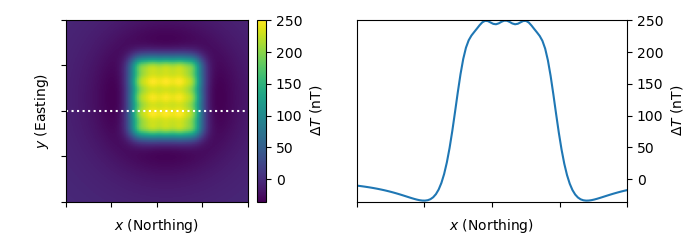

In [10]:
cmap = 'viridis'
fig, axs = plt.subplots(1, 2, figsize=(7, 2.5), sharex=True)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax = axs[0]
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
ax.set_xlabel(r'$x$ (Northing)')
ax.set_ylabel(r'$y$ (Easting)')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.plot([x.min(), x.max()], [0, 0], ':w')
dT0 = calculer_dipole(x, y, z, **p0)[:, :, 0]
im = ax.imshow(dT0, cmap=cmap, extent=(x.min(), x.max(), y.min(), y.max()))
cb = fig.colorbar(im, cax=cax, label='$\Delta T$ (nT)')

ax = axs[1]
line, = ax.plot(x[0, :, 0], dT0[x.shape[0]//2])
ax.set_xlim([x.min(), x.max()])
ax.set_ylim([dT0.min(), dT0.max()])
ax.set_xlabel(r'$x$ (Northing)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel(r'$\Delta T$ (nT)')
plt.tight_layout()

def update(**kwargs):
    dT = calculer_dipole(x, y, z, **kwargs)[:, :, 0]
    vmax = np.max(dT)
    vmin = np.min(dT)
    im.set_data(dT)
    im.set_clim(vmin, vmax)
    axs[1].set_ylim([vmin, vmax])
    line.set_ydata(dT[x.shape[0]//2])  

widget = interactive(update, **params)
controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]));